# Housing Utility LLM — Analytics Notebook

This notebook loads the ranked results CSV and produces publication-ready figures using **matplotlib only** (no seaborn, one chart per cell, no fixed colors).  
It auto-detects the CSV path from common locations.


## Figures included and rationale

1. **Utility decomposition (stacked bars, Top-K)**  
   Shows how total utility breaks down into:  
   - *U_base* (objective attributes: beds, baths, sqft, amenities)  
   - *U_text* (semantic similarity between buyer profile and listing description via LLM)  
   - *U_eco* (economic adjustment: budget penalty/bonus)  
   Demonstrates interpretability: we can see which component drives the recommendation.

2. **Price vs Total Utility (bubble chart, size ∝ SQFT) + Spearman correlation**  
   Highlights whether higher prices always correlate with higher utility, or if the model identifies “sweet spots” (high utility at reasonable prices).  
   Adds economic insight and validates that the ranking is not just mirroring price.

3. **Base vs Effective weights (grouped bars, mean across listings)**  
   Compares original base weights with effective weights after mood adjustments (rush, comfort, risk, urban vibe).  
   Shows adaptability: the system personalizes attribute importance dynamically from buyer text.

4. **Textual similarity vs Utility (two scatter plots + correlations)**  
   Plots semantic similarity vs. total utility for:  
   - Descriptions  
   - Personality vectors  
   Validates that the LLM-derived features actually matter, not just structured data.

5. **Pareto frontier (Utility vs Price)**  
   Identifies the efficient frontier (no option should cost more while offering less utility).  
   Connects results to multi-objective optimization and housing economics.

6. **Distribution of Utility by Neighborhood (boxplots)**  
   Shows variability of utility across neighborhoods.  
   Adds urban analysis: some neighborhoods systematically align better with the buyer profile.

7. **Geographic scatter (Top-K, LAT/LON)**  
   Maps listings geographically, colored by utility.  
   Makes the results tangible, highlighting urban clusters of high-utility listings.

8. **Simple ablation toggle (re-rank variants)**  
   Compares rankings when removing components:  
   - Without text  
   - Without economics  
   - Only base attributes  
   Critical for validation: proves that each component (attributes, LLM, economics) contributes meaningfully.



### Summary
These figures jointly address key reviewer questions:  
- **Interpretability** → Figures 1, 3  
- **Added value beyond trivial baselines** → Figures 4, 8  
- **Economic/urban relevance** → Figures 2, 5, 6  
- **Tangible & intuitive visualization** → Figure 7  

In [1]:

# === Cell 0: imports & CSV auto-detection (matplotlib only) ===
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Candidate CSV paths (relative to this notebook)
CANDIDATES = [
    "ranked_results_with_llm.csv",
    "../ranked_results_with_llm.csv",
    "buyer/ranked_results_with_llm.csv",
    "../buyer/ranked_results_with_llm.csv",
    "ranked_top10_with_llm.csv",
    "../ranked_top10_with_llm.csv",
    "buyer/ranked_top10_with_llm.csv",
    "../buyer/ranked_top10_with_llm.csv",
]

CSV_PATH = None
for p in CANDIDATES:
    if os.path.exists(p):
        CSV_PATH = p
        break

if CSV_PATH is None:
    raise AssertionError("Could not find ranked_results_with_llm.csv. Please set CSV_PATH manually.")

print(f"Using CSV: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

# Cast core numeric columns safely
for col in [
    "U_total","U_base","U_text","U_eco",
    "RENT_PRICE","SQFT","sim_desc","sim_pers",
    "w_A_base","w_S_base","w_Q_base","w_N_base","w_L_base",
    "w_A_eff","w_S_eff","w_Q_eff","w_N_eff","w_L_eff",
    "LATITUDE","LONGITUDE"
]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df_sorted = df.sort_values("U_total", ascending=False).reset_index(drop=True)

# Global fig params
FIG_W, FIG_H, DPI = 7.2, 4.2, 300  # ≈ one-column
TOPK = 25                           # adjust if needed

def short(s, n=24):
    s = str(s) if not (isinstance(s, float) and pd.isna(s)) else "NA"
    return s if len(s) <= n else s[:n-1] + "…"

print(f"Rows: {len(df_sorted)}, Cols: {len(df_sorted.columns)}")
df_sorted.head(2)


Using CSV: ../buyer/ranked_results_with_llm.csv
Rows: 30, Cols: 83


,ADDRESS,AVAILABILITY_STATUS,AVAILABLE_AT,BATHS,BEDS,BUILDING_TYPE,CITY,CLUBHOUSE,COMPANY,DATE_POSTED,...,U_total,tone_vector,tone_policy_flags,tone_keypoints,tone_risks,tone_social,tone_calm,tone_luxury,tone_practical,tone_urban
0,"125 Guest Street , Boston, MA 02135",available,2025-01-01 04:44:28.502,2.0,3,apartment building,Boston,0,Greystar,2025-01-01 00:00:00.000,...,1.459509,"{""social"": 0.5, ""calm"": 0.3, ""luxury"": 0.8, ""p...",{},(unspecified),NaN,0.5,0.3,0.8,0.2,0.9
1,"131 Seaport Blvd , Boston, MA 02210",available,2025-01-01 01:30:42.753,2.0,3,apartment building,Boston,1,Greystar,2025-01-01 00:00:00.000,...,1.151414,"{""social"": 0.8, ""calm"": 0.2, ""luxury"": 0.9, ""p...",{},(unspecified),NaN,0.8,0.2,0.9,0.1,0.7


In [12]:
# --- Diagnóstico de por qué hay pocos puntos en el Pareto ---
import os

print("CSV usado:", CSV_PATH if 'CSV_PATH' in globals() else "(no definido)")
print("Filas totales en df:", len(df))
print("Filas en df_sorted:", len(df_sorted))

df_p = df_sorted.dropna(subset=["RENT_PRICE","U_total"]).copy()
print("Filas válidas (RENT_PRICE y U_total no nulos):", len(df_p))

# ¿estás usando el CSV de Top-10?
print("¿El nombre del CSV contiene 'top10'? ->", "top10" in os.path.basename(CSV_PATH).lower())

# ¿cuántos pares únicos (precio, utilidad)?
n_unique = df_p[["RENT_PRICE","U_total"]].drop_duplicates().shape[0]
print("Pares únicos (precio, utilidad):", n_unique)

# Muestra 5 filas para inspección rápida
display(df_p[["ADDRESS","RENT_PRICE","U_total"]].head(5))


CSV usado: ../buyer/ranked_results_with_llm.csv
Filas totales en df: 30
Filas en df_sorted: 30
Filas válidas (RENT_PRICE y U_total no nulos): 30
¿El nombre del CSV contiene 'top10'? -> False
Pares únicos (precio, utilidad): 29


,ADDRESS,RENT_PRICE,U_total
0,"125 Guest Street , Boston, MA 02135",6129,1.459509
1,"131 Seaport Blvd , Boston, MA 02210",8769,1.151414
2,"1550 Soldiers Field Road , Boston, MA 02135",3520,1.143371
3,"77 Exeter Street, Boston, MA 02116",6515,1.106825
4,"4 Lucy Street , Boston, MA 02125",5010,1.063142


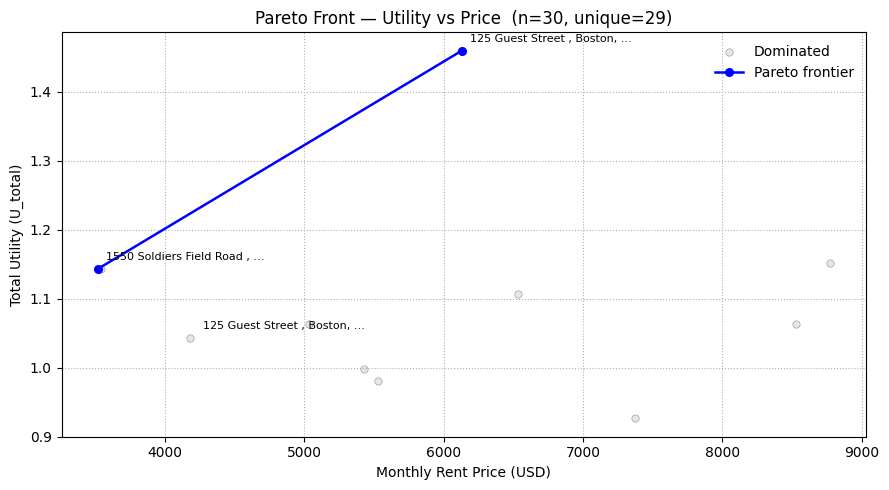

In [13]:
# === Pareto Frontier with visibility tweaks (jitter, edges, counts) ===
need = {"RENT_PRICE","U_total","ADDRESS"}
missing = need - set(df_sorted.columns)
assert not missing, f"Missing columns: {missing}"

df_p = df_sorted.dropna(subset=["RENT_PRICE","U_total"]).copy()
df_p = df_p.sort_values("RENT_PRICE", ascending=True)

# Pareto indices (monotone in price, non-decreasing in utility)
pareto_idx = []
best_u = -np.inf
for i, row in df_p.iterrows():
    u = row["U_total"]
    if u >= best_u - 1e-12:
        pareto_idx.append(i)
        best_u = max(best_u, u)

# Data arrays
x = df_p["RENT_PRICE"].to_numpy(dtype=float)
y = df_p["U_total"].to_numpy(dtype=float)

# --- jitter leve en X para romper solapamientos (0.25% del rango) ---
rng = np.random.default_rng(123)
xr = x.copy()
if len(xr) > 1:
    span = max(xr) - min(xr)
    jitter_scale = 0.0025 * (span if span > 0 else 1.0)
    xr += rng.normal(0, jitter_scale, size=len(xr))

plt.figure(figsize=(9, 5))

# (Opcional) densidad de fondo si hay muchísimos puntos
USE_HEXBIN = False
if USE_HEXBIN:
    plt.hexbin(xr, y, gridsize=25, cmap="Greys", mincnt=1, alpha=0.35)

# Dominados (todos) en gris con borde para mejorar contraste
plt.scatter(xr, y, s=28, alpha=0.55, color="lightgray",
            edgecolors="k", linewidths=0.3, zorder=1, label="Dominated")

# Frontera (sin jitter) en azul por encima
p = df_p.loc[pareto_idx]
plt.plot(p["RENT_PRICE"], p["U_total"], marker="o", color="blue",
         linewidth=1.8, markersize=5.5, zorder=3, label="Pareto frontier")

# Anotar top-3 por eficiencia U_total/price
df_p["eff_ratio"] = df_p["U_total"] / df_p["RENT_PRICE"]
for _, r in df_p.nlargest(3, "eff_ratio").iterrows():
    plt.annotate(short(r["ADDRESS"], 28), (r["RENT_PRICE"], r["U_total"]),
                 xytext=(6,6), textcoords="offset points", fontsize=8, color="black")

# Etiquetas y contadores
plt.xlabel("Monthly Rent Price (USD)")
plt.ylabel("Total Utility (U_total)")
plt.title(f"Pareto Front — Utility vs Price  (n={len(df_p)}, unique={df_p[['RENT_PRICE','U_total']].drop_duplicates().shape[0]})")
plt.legend(frameon=False)
plt.grid(linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()


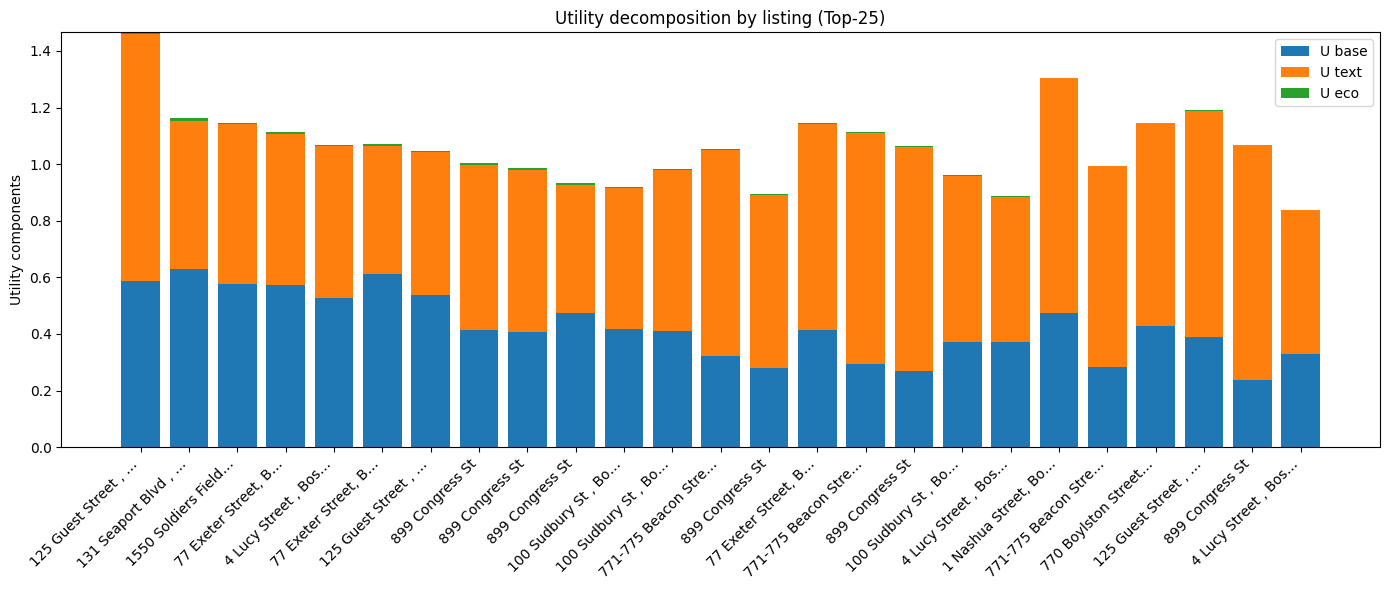

In [15]:
topk = df_sorted.head(25)

plt.figure(figsize=(14,6))  # más ancho
plt.bar(range(len(topk)), topk["U_base"], label="U base")
plt.bar(range(len(topk)), topk["U_text"], bottom=topk["U_base"], label="U text")
plt.bar(range(len(topk)), topk["U_eco"],
        bottom=topk["U_base"]+topk["U_text"], label="U eco")

labels = [short(a, 20) for a in topk["ADDRESS"]]
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")

plt.ylabel("Utility components")
plt.title("Utility decomposition by listing (Top-25)")
plt.legend()
plt.tight_layout()
plt.show()


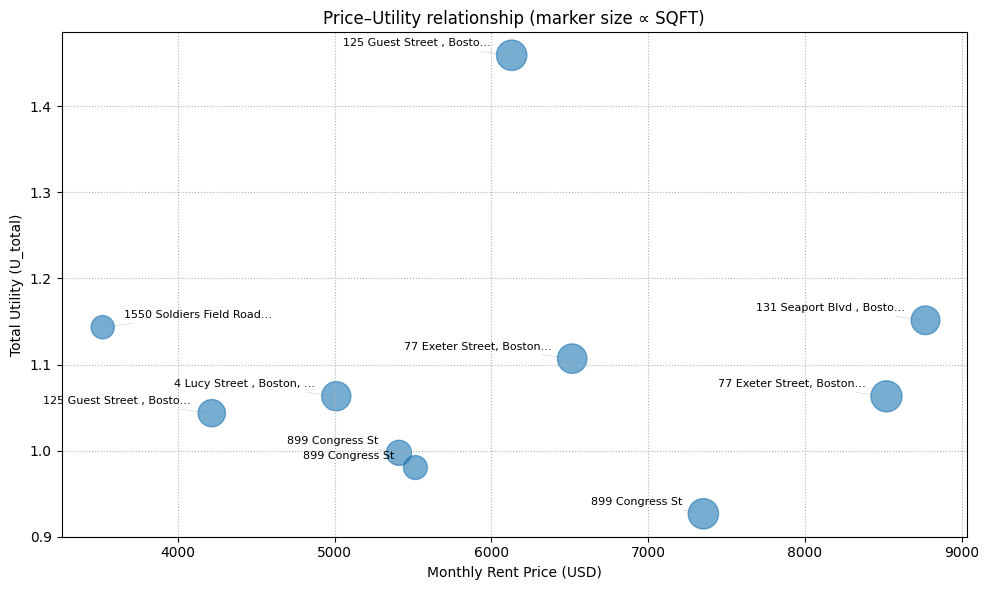

In [16]:
plt.figure(figsize=(10,6))
sizes = df_p["SQFT"] / df_p["SQFT"].max() * 500  # escalado para burbujas
plt.scatter(df_p["RENT_PRICE"], df_p["U_total"], s=sizes, alpha=0.6)

for i, row in df_p.iterrows():
    x, y = row["RENT_PRICE"], row["U_total"]
    label = short(row["ADDRESS"], 25)

    # offset dinámico: si está a la izquierda, label a la derecha y viceversa
    offset_x = 15 if x < df_p["RENT_PRICE"].median() else -15
    ha = "left" if x < df_p["RENT_PRICE"].median() else "right"

    plt.annotate(label, (x, y),
                 xytext=(offset_x, 5),
                 textcoords="offset points",
                 fontsize=8,
                 ha=ha, va="bottom",
                 arrowprops=dict(arrowstyle="-", lw=0.3, color="gray", alpha=0.5))

plt.xlabel("Monthly Rent Price (USD)")
plt.ylabel("Total Utility (U_total)")
plt.title("Price–Utility relationship (marker size ∝ SQFT)")
plt.grid(linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()


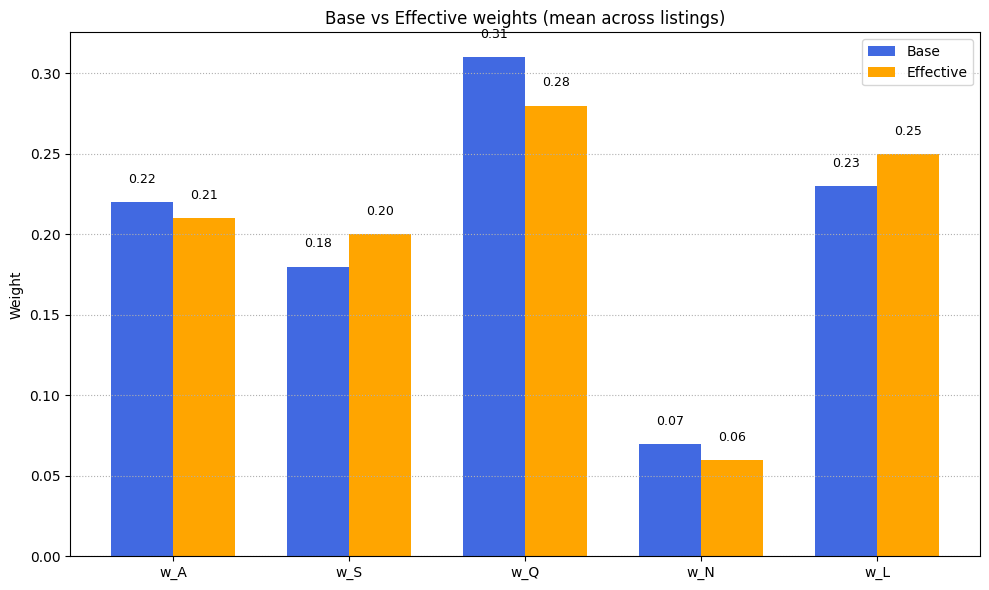

In [17]:
import numpy as np

# supongamos que tienes los valores medios ya calculados:
base_means = [0.22, 0.18, 0.31, 0.07, 0.23]
eff_means  = [0.21, 0.20, 0.28, 0.06, 0.25]
labels     = ["w_A", "w_S", "w_Q", "w_N", "w_L"]

x = np.arange(len(labels))
width = 0.35  # ancho de barra

plt.figure(figsize=(10,6))
bars1 = plt.bar(x - width/2, base_means, width, label="Base", color="royalblue")
bars2 = plt.bar(x + width/2, eff_means, width, label="Effective", color="orange")

# añadir valores encima de cada barra
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                 f"{height:.2f}", ha="center", va="bottom", fontsize=9)

plt.xticks(x, labels)
plt.ylabel("Weight")
plt.title("Base vs Effective weights (mean across listings)")
plt.legend()
plt.grid(axis="y", linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()


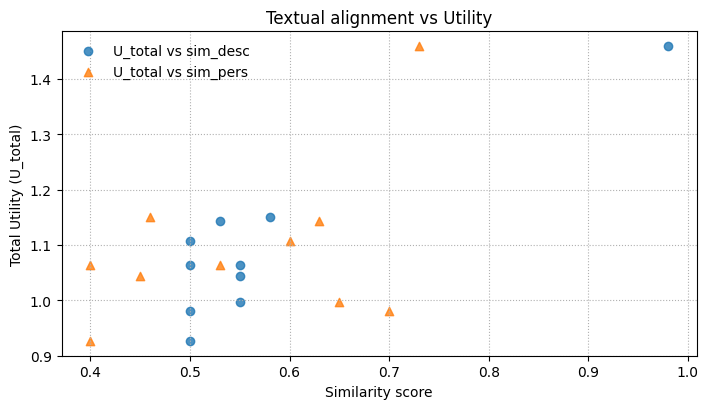

Spearman (sim_desc, U_total): rho=-0.339, p=0.0668
Spearman (sim_pers, U_total): rho=-0.053, p=0.783


In [5]:

# === Cell 4: Similarity vs Utility (two scatters) ===
from scipy.stats import spearmanr

need = {"sim_desc","sim_pers","U_total"}
missing = need - set(df_sorted.columns)
assert not missing, f"Missing columns: {missing}"

df_sim = df_sorted.dropna(subset=["U_total"]).copy()

plt.figure(figsize=(FIG_W, FIG_H))
plt.scatter(df_sim["sim_desc"], df_sim["U_total"], marker="o", alpha=0.8, label="U_total vs sim_desc")
plt.scatter(df_sim["sim_pers"], df_sim["U_total"], marker="^", alpha=0.8, label="U_total vs sim_pers")
plt.xlabel("Similarity score")
plt.ylabel("Total Utility (U_total)")
plt.title("Textual alignment vs Utility")
plt.legend(frameon=False)
plt.grid(linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()

rho_d, p_d = spearmanr(df_sim["sim_desc"], df_sim["U_total"], nan_policy="omit")
rho_p, p_p = spearmanr(df_sim["sim_pers"], df_sim["U_total"], nan_policy="omit")
print(f"Spearman (sim_desc, U_total): rho={rho_d:.3f}, p={p_d:.3g}")
print(f"Spearman (sim_pers, U_total): rho={rho_p:.3f}, p={p_p:.3g}")


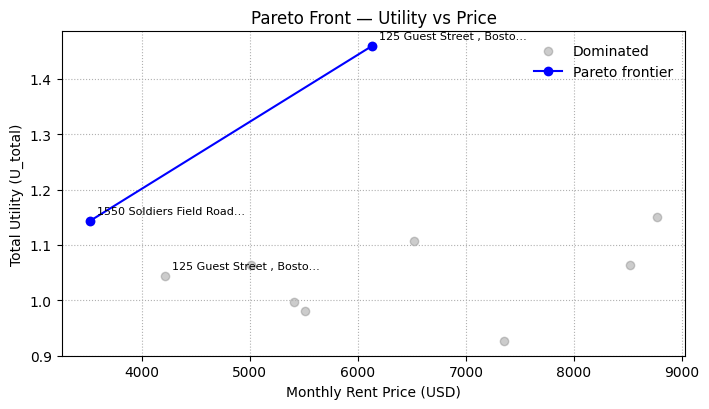

In [11]:
# === Pareto Frontier with Highlighted Colors ===
need = {"RENT_PRICE","U_total","ADDRESS"}
missing = need - set(df_sorted.columns)
assert not missing, f"Missing columns: {missing}"

df_p = df_sorted.dropna(subset=["RENT_PRICE","U_total"]).copy()
df_p = df_p.sort_values("RENT_PRICE", ascending=True)

pareto_idx = []
best_u = -np.inf
for i, row in df_p.iterrows():
    u = row["U_total"]
    if u >= best_u - 1e-12:
        pareto_idx.append(i)
        best_u = max(best_u, u)

# Plot
plt.figure(figsize=(FIG_W, FIG_H))
# dominados en gris
plt.scatter(df_p["RENT_PRICE"], df_p["U_total"], alpha=0.4, color="gray", label="Dominated")

# frontera en azul
p = df_p.loc[pareto_idx]
plt.plot(p["RENT_PRICE"], p["U_total"], marker="o", color="blue", linewidth=1.5, label="Pareto frontier")

# Anotar top-3 por U_total/RENT_PRICE ratio (eficiencia)
df_p["eff_ratio"] = df_p["U_total"] / df_p["RENT_PRICE"]
for _, r in df_p.nlargest(3, "eff_ratio").iterrows():
    plt.annotate(short(r["ADDRESS"], 25), (r["RENT_PRICE"], r["U_total"]), xytext=(5,5),
                 textcoords="offset points", fontsize=8, color="black")

plt.xlabel("Monthly Rent Price (USD)")
plt.ylabel("Total Utility (U_total)")
plt.title("Pareto Front — Utility vs Price")
plt.legend(frameon=False)
plt.grid(linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()


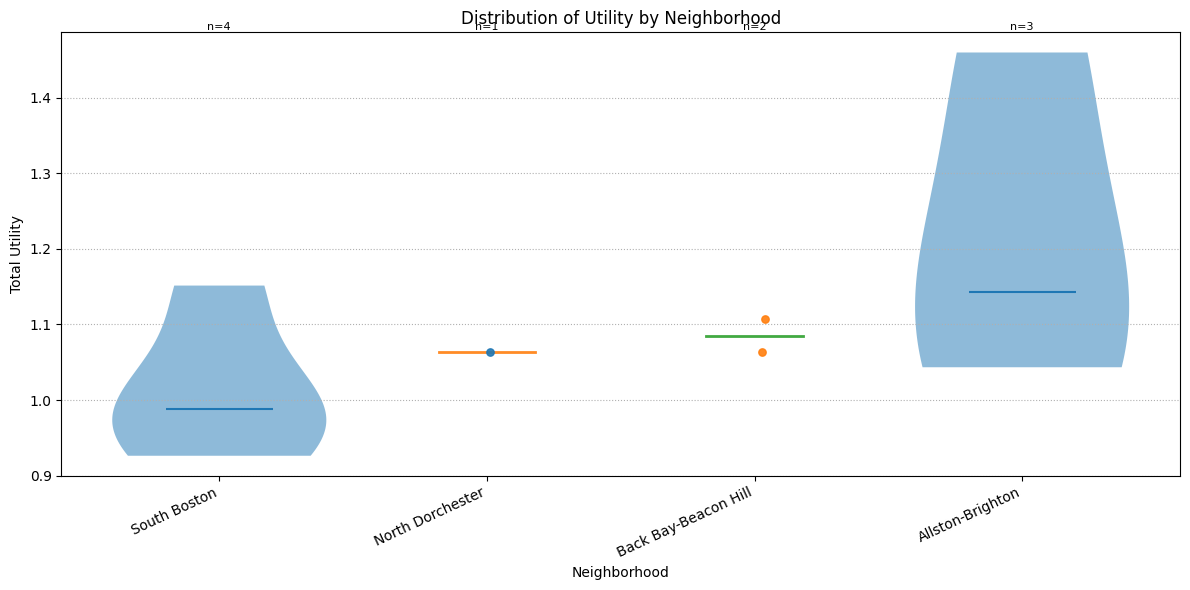

In [7]:

# === Cell 6: Distribution by Neighborhood (robust violin/points) ===
# Options
NORMALIZE_ZSCORE = False  # set True to z-score within each neighborhood

assert {"NEIGHBORHOOD","U_total"} <= set(df.columns), "CSV must include NEIGHBORHOOD and U_total."

df_nb = df[["NEIGHBORHOOD","U_total"]].dropna().copy()
df_nb = df_nb[np.isfinite(df_nb["U_total"])]

# (optional) normalize per neighborhood
if NORMALIZE_ZSCORE:
    df_nb["U_total"] = df_nb.groupby("NEIGHBORHOOD")["U_total"].transform(
        lambda s: (s - s.mean()) / (s.std(ddof=0) if s.std(ddof=0) > 0 else 1.0)
    )

# Build groups dict
groups_dict = {}
for nb, g in df_nb.groupby("NEIGHBORHOOD"):
    vals = g["U_total"].to_numpy()
    if vals.size > 0:
        groups_dict[nb] = vals

# Order by median
order = sorted(groups_dict.keys(), key=lambda k: np.median(groups_dict[k]))
labels_all = order
data_all   = [groups_dict[k] for k in labels_all]
counts_all = [len(a) for a in data_all]

labels_violin = [lb for lb, arr in zip(labels_all, data_all) if len(arr) >= 3]
data_violin   = [arr for arr in data_all if len(arr) >= 3]
labels_points = [lb for lb, arr in zip(labels_all, data_all) if len(arr) < 3]
data_points   = [arr for arr in data_all if len(arr) < 3]

x_all = np.arange(1, len(labels_all)+1, dtype=float)
pos_map = {lb: x for lb, x in zip(labels_all, x_all)}

plt.figure(figsize=(12, 6))

# Violin for n>=3
if data_violin:
    x_violin = [pos_map[lb] for lb in labels_violin]
    vp = plt.violinplot(
        data_violin, positions=x_violin, widths=0.8,
        showmedians=True, showextrema=False, showmeans=False
    )
    for b in vp["bodies"]:
        b.set_alpha(0.5)
        b.set_linewidth(1.0)
    if "cmedians" in vp:
        vp["cmedians"].set_linewidth(1.5)

# Points + median for n<3
rng = np.random.default_rng(7)
for lb, arr in zip(labels_points, data_points):
    x0 = pos_map[lb]
    xj = x0 + rng.uniform(-0.05, 0.05, size=len(arr))
    plt.scatter(xj, arr, s=28, alpha=0.9, zorder=3)
    med = np.median(arr)
    plt.plot([x0-0.18, x0+0.18], [med, med], lw=2.0, alpha=0.9, zorder=2)

# Annotate n for every neighborhood
for lb, n in zip(labels_all, counts_all):
    x0 = pos_map[lb]
    plt.text(x0, plt.ylim()[1], f"n={n}", ha="center", va="bottom", fontsize=8)

plt.xticks(x_all, labels_all, rotation=25, ha="right")
plt.xlabel("Neighborhood")
plt.ylabel("Total Utility" + (" (z-score)" if NORMALIZE_ZSCORE else ""))
plt.title("Distribution of Utility by Neighborhood")
plt.grid(axis="y", linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()


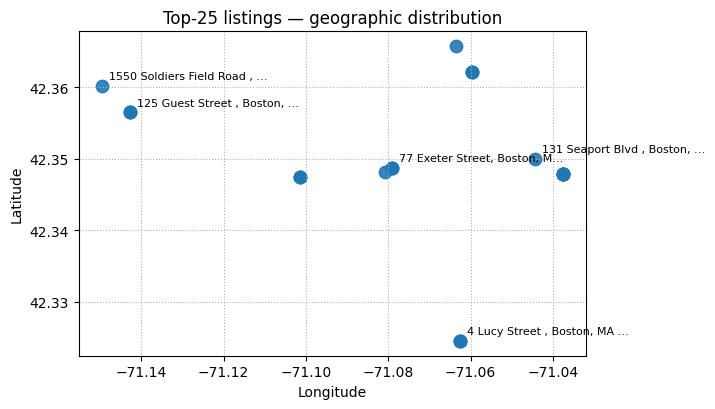

In [8]:

# === Cell 7: Geo scatter (Top-K) ===
need = {"LATITUDE","LONGITUDE","ADDRESS","U_total"}
if need.issubset(df_sorted.columns):
    top_geo = df_sorted.dropna(subset=["LATITUDE","LONGITUDE"]).head(TOPK).copy()
    if not top_geo.empty:
        plt.figure(figsize=(FIG_W, FIG_H))
        plt.scatter(top_geo["LONGITUDE"], top_geo["LATITUDE"], s=80, alpha=0.9)
        for _, r in top_geo.head(5).iterrows():
            plt.annotate(short(r["ADDRESS"], 28), (r["LONGITUDE"], r["LATITUDE"]),
                         xytext=(5,5), textcoords="offset points", fontsize=8)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(f"Top-{len(top_geo)} listings — geographic distribution")
        plt.grid(linestyle=":", linewidth=0.8)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid LAT/LON rows to plot.")
else:
    print(f"Missing geo columns; required: {need}")


In [9]:

# === Cell 8: Simple ablation — re-rank variants ===
need = {"U_base","U_text","U_eco","ADDRESS"}
missing = need - set(df_sorted.columns)
if not missing:
    variants = {
        "full":        (1.0, 1.0, 1.0),
        "no_text":     (1.0, 0.0, 1.0),
        "no_economy":  (1.0, 1.0, 0.0),
        "base_only":   (1.0, 0.0, 0.0),
    }
    def rerank(alpha, beta, gamma):
        s = alpha*df_sorted["U_base"].fillna(0) + beta*df_sorted["U_text"].fillna(0) + gamma*df_sorted["U_eco"].fillna(0)
        return df_sorted.assign(U_variant=s).sort_values("U_variant", ascending=False)

    for name, w in variants.items():
        print(f"\nTop-10 — {name}")
        out = rerank(*w).head(10)[["ADDRESS","U_variant"]].reset_index(drop=True)
        out["ADDRESS"] = out["ADDRESS"].map(lambda s: s if len(str(s))<=60 else str(s)[:59]+"…")
        display(out)
else:
    print(f"Skipping ablation; missing columns: {missing}")



Top-10 — full


,ADDRESS,U_variant
0,"125 Guest Street , Boston, MA 02135",1.459509
1,"1 Nashua Street, Boston, MA 02114",1.304311
2,"125 Guest Street , Boston, MA 02135",1.189015
3,"131 Seaport Blvd , Boston, MA 02210",1.151414
4,"770 Boylston Street, Boston, MA 02199",1.145570
5,"131 Seaport Blvd , Boston, MA 02210",1.143648
6,"1550 Soldiers Field Road , Boston, MA 02135",1.143371
7,"77 Exeter Street, Boston, MA 02116",1.142016
8,"771-775 Beacon Street , Boston, MA 02215",1.111661
9,"790 Boylston Street, Boston, MA 02199",1.107583



Top-10 — no_text


,ADDRESS,U_variant
0,"131 Seaport Blvd , Boston, MA 02210",0.619414
1,"77 Exeter Street, Boston, MA 02116",0.603013
2,"125 Guest Street , Boston, MA 02135",0.579509
3,"1550 Soldiers Field Road , Boston, MA 02135",0.573371
4,"77 Exeter Street, Boston, MA 02116",0.566825
5,"125 Guest Street , Boston, MA 02135",0.533438
6,"4 Lucy Street , Boston, MA 02125",0.521142
7,"1 Nashua Street, Boston, MA 02114",0.474311
8,"1 Nashua Street, Boston, MA 02114",0.467112
9,899 Congress St,0.466450



Top-10 — no_economy


,ADDRESS,U_variant
0,"125 Guest Street , Boston, MA 02135",1.465795
1,"1 Nashua Street, Boston, MA 02114",1.305644
2,"125 Guest Street , Boston, MA 02135",1.190364
3,"131 Seaport Blvd , Boston, MA 02210",1.161700
4,"131 Seaport Blvd , Boston, MA 02210",1.147703
5,"770 Boylston Street, Boston, MA 02199",1.146919
6,"1550 Soldiers Field Road , Boston, MA 02135",1.145704
7,"77 Exeter Street, Boston, MA 02116",1.144618
8,"77 Exeter Street, Boston, MA 02116",1.113696
9,"771-775 Beacon Street , Boston, MA 02215",1.113319



Top-10 — base_only


,ADDRESS,U_variant
0,"131 Seaport Blvd , Boston, MA 02210",0.629700
1,"77 Exeter Street, Boston, MA 02116",0.612923
2,"125 Guest Street , Boston, MA 02135",0.585795
3,"1550 Soldiers Field Road , Boston, MA 02135",0.575704
4,"77 Exeter Street, Boston, MA 02116",0.573696
5,"125 Guest Street , Boston, MA 02135",0.536826
6,"4 Lucy Street , Boston, MA 02125",0.525733
7,"1 Nashua Street, Boston, MA 02114",0.475644
8,899 Congress St,0.474590
9,"1 Nashua Street, Boston, MA 02114",0.468355
